# Xopt basic example

An Xopt problem can be described by a simple YAML file. Here we will demonstrate how this is used to optimize a well-known constrained multi-objective test function, TNK. The TNK function is defined with:

$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [1]:
# Import the class
from xopt import Xopt

In [2]:
# Nicer plotting
%config InlineBackend.figure_format = 'retina'

## Xopt Components
The definition of the Xopt object requires 4 parts, listed below:
- The `Evaluator` object, which evaluates input points using the arbitrary function
specified by the `function` property.
- The `Generator` object, which, when given data that has been evaluated, generates
future points to evaluate using the evaluator.
- The `VOCS` (variables, objectives, constraints, statics) object, which specifies the
input domain, the objectives, constraints and constants passed to the evaluator
function.

Through the YAML interface these objects and their options are specified by name. 
Here we will make one:

In [3]:
# Make a proper input file.
YAML = """
evaluator:
    function: xopt.resources.test_functions.tnk.evaluate_TNK
    function_kwargs:
        a: 999

generator:
    name: random

vocs:
    variables:
        x1: [0, 3.14159]
        x2: [0, 3.14159]
    objectives: {y1: MINIMIZE, y2: MINIMIZE}
    constraints:
        c1: [GREATER_THAN, 0]
        c2: [LESS_THAN, 0.5]
    constants: {a: dummy_constant}

"""

In [4]:
# create Xopt object.

X = Xopt.from_yaml(YAML)

In [5]:
# Convenient representation of the state.
X


            Xopt
________________________________
Version: 0+untagged.1.gc8a1007
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: !!python/name:xopt.resources.test_functions.tnk.evaluate_TNK ''
  function_kwargs:
    a: 999
    raise_probability: 0
    random_sleep: 0
    sleep: 0
  max_workers: 1
  vectorized: false
generator:
  name: random
max_evaluations: null
serialize_torch: false
strict: true
vocs:
  constants:
    a: dummy_constant
  constraints:
    c1:
    - GREATER_THAN
    - 0.0
    c2:
    - LESS_THAN
    - 0.5
  objectives:
    y1: MINIMIZE
    y2: MINIMIZE
  observables: []
  variables:
    x1:
    - 0.0
    - 3.14159
    x2:
    - 0.0
    - 3.14159


In [6]:
X.random_evaluate(10)

,x1,x2,a,y1,y2,c1,c2,xopt_runtime,xopt_error
0,2.611332,2.212617,dummy_constant,2.611332,2.212617,10.689862,7.390783,0.000080,False
1,3.102058,1.813642,dummy_constant,3.102058,1.813642,11.969427,8.496358,0.000010,False
2,1.114443,1.461009,dummy_constant,1.114443,1.461009,2.430444,1.301080,0.000008,False
3,1.473678,1.921378,dummy_constant,1.473678,1.921378,4.913714,2.968364,0.000007,False
4,2.039167,2.375641,dummy_constant,2.039167,2.375641,8.767234,5.887064,0.000007,False
5,2.113149,2.608626,dummy_constant,2.113149,2.608626,10.280514,7.048553,0.000007,False
6,2.819261,0.346642,dummy_constant,2.819261,0.346642,7.106100,5.402488,0.000008,False
7,1.016506,0.955111,dummy_constant,1.016506,0.955111,0.857672,0.473905,0.000006,False
8,2.667279,0.230637,dummy_constant,2.667279,0.230637,6.148614,4.769656,0.000006,False
9,1.868195,2.579279,dummy_constant,1.868195,2.579279,9.225088,6.195359,0.000006,False


## Run Random data generation

In [7]:
import numpy as np
np.random.seed(10)

In [8]:
# Take one step (generate a single point)
X.step()

In [9]:
# examine the results
X.data

,x1,x2,a,y1,y2,c1,c2,xopt_runtime,xopt_error
0,2.611332,2.212617,dummy_constant,2.611332,2.212617,10.689862,7.390783,0.000080,False
1,3.102058,1.813642,dummy_constant,3.102058,1.813642,11.969427,8.496358,0.000010,False
2,1.114443,1.461009,dummy_constant,1.114443,1.461009,2.430444,1.30108,0.000008,False
3,1.473678,1.921378,dummy_constant,1.473678,1.921378,4.913714,2.968364,0.000007,False
4,2.039167,2.375641,dummy_constant,2.039167,2.375641,8.767234,5.887064,0.000007,False
5,2.113149,2.608626,dummy_constant,2.113149,2.608626,10.280514,7.048553,0.000007,False
6,2.819261,0.346642,dummy_constant,2.819261,0.346642,7.1061,5.402488,0.000008,False
7,1.016506,0.955111,dummy_constant,1.016506,0.955111,0.857672,0.473905,0.000006,False
8,2.667279,0.230637,dummy_constant,2.667279,0.230637,6.148614,4.769656,0.000006,False
9,1.868195,2.579279,dummy_constant,1.868195,2.579279,9.225088,6.195359,0.000006,False


In [10]:
# take a couple of steps and examine the results
for _ in range(10):
    X.step()
X.data

,x1,x2,a,y1,y2,c1,c2,xopt_runtime,xopt_error
0,2.611332,2.212617,dummy_constant,2.611332,2.212617,10.689862,7.390783,0.000080,False
1,3.102058,1.813642,dummy_constant,3.102058,1.813642,11.969427,8.496358,0.000010,False
2,1.114443,1.461009,dummy_constant,1.114443,1.461009,2.430444,1.30108,0.000008,False
3,1.473678,1.921378,dummy_constant,1.473678,1.921378,4.913714,2.968364,0.000007,False
4,2.039167,2.375641,dummy_constant,2.039167,2.375641,8.767234,5.887064,0.000007,False
5,2.113149,2.608626,dummy_constant,2.113149,2.608626,10.280514,7.048553,0.000007,False
6,2.819261,0.346642,dummy_constant,2.819261,0.346642,7.1061,5.402488,0.000008,False
7,1.016506,0.955111,dummy_constant,1.016506,0.955111,0.857672,0.473905,0.000006,False
8,2.667279,0.230637,dummy_constant,2.667279,0.230637,6.148614,4.769656,0.000006,False
9,1.868195,2.579279,dummy_constant,1.868195,2.579279,9.225088,6.195359,0.000006,False


## Plotting
Plot the objective results

<Axes: xlabel='y1', ylabel='y2'>

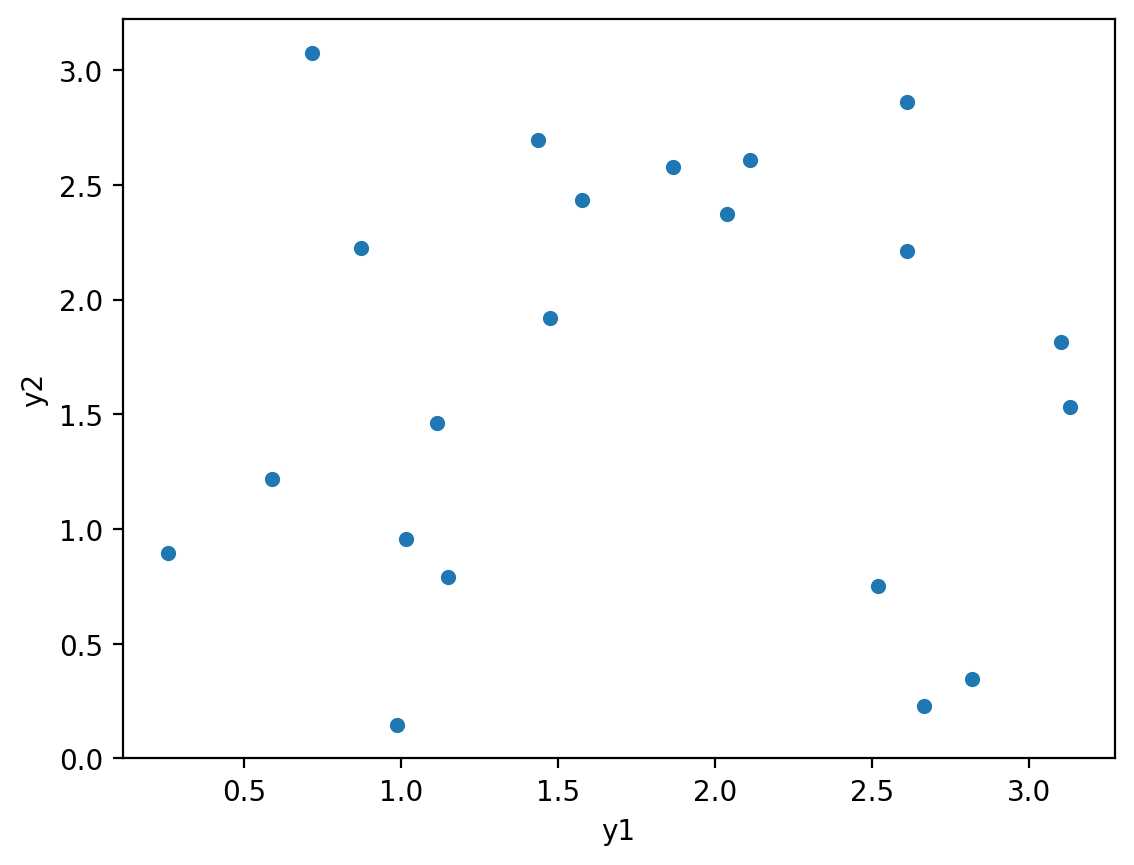

In [11]:
import matplotlib.pyplot as plt

X.data.plot(*X.vocs.objective_names, kind="scatter")

## Alternative initialization methods

For convenience you can also use ```Xopt.from_dict``` to create Xopt objects from dictionaries.

In [12]:
import yaml

config  = yaml.safe_load(YAML)
X = Xopt.from_dict(config)


## Convenience Methods

In [13]:
# convenience method for evaluating a random sample
X.random_evaluate()

,x1,x2,a,y1,y2,c1,c2,xopt_runtime,xopt_error
0,1.968706,1.023739,dummy_constant,1.968706,1.023739,3.905785,2.431401,0.000085,False


In [14]:
X.random_evaluate(5)

,x1,x2,a,y1,y2,c1,c2,xopt_runtime,xopt_error
0,1.753531,1.253372,dummy_constant,1.753531,1.253372,3.733363,2.138910,0.000061,False
1,1.778096,0.611909,dummy_constant,1.778096,0.611909,2.480365,1.646053,0.000029,False
2,1.200819,1.502789,dummy_constant,1.200819,1.502789,2.721078,1.496733,0.000014,False
3,1.529520,0.286988,dummy_constant,1.529520,0.286988,1.520284,1.105286,0.000014,False
4,1.098309,2.138681,dummy_constant,1.098309,2.138681,4.754223,3.043249,0.000012,False


## Logging

Normally Xopt will not issue print statments, and instead issue logging messages. Below will enable these to be seen in the notebook

In [15]:
# Notebook printing output
from xopt import output_notebook
output_notebook()

In [16]:
X.step()

Running Xopt step
